<a href="https://colab.research.google.com/github/Aardra27/AQI-Prediction-ML/blob/main/AQI_Prediction_ML.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **1. Imports**

In [1]:
# %%
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import joblib
import warnings
warnings.filterwarnings("ignore")

from sklearn.model_selection import train_test_split, cross_val_score, RandomizedSearchCV
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder, StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer

from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, AdaBoostRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error

# Optional: use xgboost if available
try:
    from xgboost import XGBRegressor
    _HAS_XGB = True
except Exception:
    _HAS_XGB = False


# **2. Upload & Load dataset (Colab file upload)**

In [2]:
# %%
from google.colab import files
import io

print("📂 Upload merged CSV file (with AQI column):")
uploaded = files.upload()
if not uploaded:
    raise RuntimeError("No file uploaded.")
csv_file = list(uploaded.keys())[0]
df = pd.read_csv(io.BytesIO(uploaded[csv_file]))
print(f"✅ Uploaded: {csv_file} -> shape: {df.shape}")
df.head()


📂 Upload merged CSV file (with AQI column):


Saving combined_air_quality_data.csv to combined_air_quality_data.csv
✅ Uploaded: combined_air_quality_data.csv -> shape: (85652, 16)


,StationId,Date,PM25,PM10,NO,NO2,NOx,NH3,CO,SO2,O3,Benzene,Toluene,Xylene,AQI,AQI_Bucket
0,AP001,2017-11-24,71.36,115.75,1.75,20.65,12.40,12.19,100.0,10.76,109.26,0.17,5.92,0.10,184.0,Moderate
1,AP001,2017-11-25,81.40,124.50,1.44,20.50,12.08,10.72,120.0,15.24,127.09,0.20,6.50,0.06,184.0,Moderate
2,AP001,2017-11-26,78.32,129.06,1.26,26.00,14.85,10.28,140.0,26.96,117.44,0.22,7.95,0.08,197.0,Moderate
3,AP001,2017-11-27,88.76,135.32,6.60,30.85,21.77,12.91,110.0,33.59,111.81,0.29,7.63,0.12,198.0,Moderate
4,AP001,2017-11-28,64.18,104.09,2.56,28.07,17.01,11.42,90.0,19.00,138.18,0.17,5.02,0.07,188.0,Moderate


# **3. Initial cleaning: drop all-empty columns, remove obvious meta cols, deduplicate**

In [13]:
# --- Fix NaN target values (AQI cannot be missing)
print("Missing AQI values before cleaning:", df['AQI'].isna().sum())

# Drop rows where AQI is NaN (required for ML training)
df = df.dropna(subset=['AQI']).reset_index(drop=True)

print("Missing AQI values after cleaning:", df['AQI'].isna().sum())
print("New shape:", df.shape)


Missing AQI values before cleaning: 0
Missing AQI values after cleaning: 0
New shape: (74615, 13)


In [14]:
# Define features and target again after cleaning
target_col = 'AQI'
X = df.drop(columns=[target_col])
y = df[target_col]

print("X shape:", X.shape)
print("y shape:", y.shape)


X shape: (74615, 12)
y shape: (74615,)


In [15]:
# Replace infinite values with NaN
X = X.replace([np.inf, -np.inf], np.nan)

# Drop rows where ALL features are NaN
mask = X.notna().any(axis=1)
X = X.loc[mask].reset_index(drop=True)
y = y.loc[mask].reset_index(drop=True)

print("Final shapes after cleaning:")
print("X:", X.shape)
print("y:", y.shape)


Final shapes after cleaning:
X: (74615, 12)
y: (74615,)


In [21]:
from sklearn.model_selection import train_test_split

xtrain, xtest, ytrain, ytest = train_test_split(
    X, y, test_size=0.2, random_state=42
)

print("Train size:", xtrain.shape, ytrain.shape)
print("Test size:", xtest.shape, ytest.shape)


Train size: (59692, 12) (59692,)
Test size: (14923, 12) (14923,)



# **4.Quick data summary & sanity checks**

In [16]:
# %%
print("Columns:", df.columns.tolist())
print("\nNull counts:")
print(df.isna().sum())
print("\nBasic stats (numeric):")
display(df.describe().round(3))

# Ensure AQI exists
if 'AQI' not in df.columns:
    raise ValueError("⚠️ 'AQI' column not found in the uploaded CSV. Rename the AQI target to 'AQI'.")


Columns: ['PM25', 'PM10', 'NO', 'NO2', 'NOx', 'NH3', 'CO', 'SO2', 'O3', 'Benzene', 'Toluene', 'Xylene', 'AQI']

Null counts:
PM25       0
PM10       0
NO         0
NO2        0
NOx        0
NH3        0
CO         0
SO2        0
O3         0
Benzene    0
Toluene    0
Xylene     0
AQI        0
dtype: int64

Basic stats (numeric):


,PM25,PM10,NO,NO2,NOx,NH3,CO,SO2,O3,Benzene,Toluene,Xylene,AQI
count,74615.000,74615.000,74615.000,74615.000,74615.000,74615.000,74615.000,74615.000,74615.000,74615.000,74615.000,74615.000,74615.000
mean,91.593,161.777,26.026,38.169,46.108,29.694,2337.173,14.082,39.116,3.476,16.745,1.950,208.419
std,83.460,116.001,36.540,31.438,46.745,22.430,6260.203,15.972,40.610,11.397,29.279,5.677,145.894
min,0.020,0.080,0.010,0.010,0.010,0.010,10.000,0.040,0.010,0.010,0.010,0.010,8.000
25%,38.100,92.580,6.120,16.760,17.910,19.050,700.000,6.490,19.925,0.810,2.740,0.720,101.000
50%,62.670,119.500,12.320,29.850,29.400,23.780,1070.000,8.960,30.420,1.470,5.030,0.720,162.000
75%,117.040,197.690,28.880,50.150,56.370,36.060,1730.000,15.760,47.500,3.700,18.820,1.910,303.000
max,1000.000,1000.000,470.000,397.770,453.610,418.900,175810.000,187.020,963.000,455.030,454.850,170.370,2049.000


# **5. Exploratory Data Analysis (quick, reproducible)**

In [17]:
# %%
target_col = 'AQI'
X = df.drop(columns=[target_col])
y = df[target_col].copy()

# Identify numeric vs categorical
numeric_features = X.select_dtypes(include=[np.number]).columns.tolist()
categorical_features = X.select_dtypes(include=['object', 'category']).columns.tolist()

print("Numeric features:", numeric_features)
print("Categorical features:", categorical_features)


Numeric features: ['PM25', 'PM10', 'NO', 'NO2', 'NOx', 'NH3', 'CO', 'SO2', 'O3', 'Benzene', 'Toluene', 'Xylene']
Categorical features: []


In [18]:
# %%
# Numeric transformer: median imputation + (optionally) scaling
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())   # scaling is harmless; tree models ignore it but LR/KNN benefit
])

# Categorical transformer: impute then one-hot (if few categories)
if categorical_features:
    categorical_transformer = Pipeline(steps=[
        ('imputer', SimpleImputer(strategy='most_frequent')),
        ('onehot', OneHotEncoder(handle_unknown='ignore', sparse=False))
    ])
    preprocessor = ColumnTransformer(
        transformers=[
            ('num', numeric_transformer, numeric_features),
            ('cat', categorical_transformer, categorical_features)
        ])
else:
    # Only numeric features present
    preprocessor = ColumnTransformer(transformers=[('num', numeric_transformer, numeric_features)])


In [19]:
# %%
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42)
print("Train shape:", X_train.shape, "Test shape:", X_test.shape)


Train shape: (59692, 12) Test shape: (14923, 12)


In [20]:
# %%
models = {
    'LinearRegression': Pipeline([('pre', preprocessor), ('model', LinearRegression())]),
    'DecisionTree': Pipeline([('pre', preprocessor), ('model', DecisionTreeRegressor(random_state=42))]),
    'RandomForest': Pipeline([('pre', preprocessor), ('model', RandomForestRegressor(n_estimators=100, random_state=42))]),
    'GradientBoosting': Pipeline([('pre', preprocessor), ('model', GradientBoostingRegressor(n_estimators=100, random_state=42))]),
    'KNeighbors': Pipeline([('pre', preprocessor), ('model', KNeighborsRegressor(n_neighbors=5))])
}

if _HAS_XGB:
    models['XGBoost'] = Pipeline([('pre', preprocessor), ('model', XGBRegressor(n_estimators=100, random_state=42, verbosity=0))])

# Evaluate with cross-validation (5-fold) — use R2
cv_results = {}
for name, pipe in models.items():
    print(f"Running CV for {name} ...")
    scores = cross_val_score(pipe, X_train, y_train, cv=5, scoring='r2', n_jobs=-1)
    cv_results[name] = scores.mean()
    print(f"  CV R2 (mean): {scores.mean():.4f} | std: {scores.std():.4f}")

# Summarize CV results
cv_df = pd.DataFrame.from_dict(cv_results, orient='index', columns=['CV_R2']).sort_values('CV_R2', ascending=False)
display(cv_df)


Running CV for LinearRegression ...
  CV R2 (mean): 0.7685 | std: 0.0067
Running CV for DecisionTree ...
  CV R2 (mean): 0.8488 | std: 0.0065
Running CV for RandomForest ...
  CV R2 (mean): 0.9184 | std: 0.0035
Running CV for GradientBoosting ...
  CV R2 (mean): 0.8792 | std: 0.0023
Running CV for KNeighbors ...
  CV R2 (mean): 0.8760 | std: 0.0051
Running CV for XGBoost ...
  CV R2 (mean): 0.9149 | std: 0.0024


,CV_R2
RandomForest,0.918447
XGBoost,0.914865
GradientBoosting,0.879240
KNeighbors,0.875975
DecisionTree,0.848793
LinearRegression,0.768521


In [22]:
# %%
def report_metrics(y_true, y_pred):
    r2 = r2_score(y_true, y_pred)
    mae = mean_absolute_error(y_true, y_pred)
    mse = mean_squared_error(y_true, y_pred)
    rmse = np.sqrt(mse)
    return {'r2': r2, 'mae': mae, 'rmse': rmse}

results = []

# Identify and remove NaN values from y_train and corresponding X_train rows
if y_train.isna().any():
    nan_indices_train = y_train[y_train.isna()].index
    print(f"Warning: {len(nan_indices_train)} NaN values found in y_train. Removing corresponding rows from X_train and y_train for training.")
    X_train_processed = X_train.drop(nan_indices_train)
    y_train_processed = y_train.drop(nan_indices_train)
else:
    X_train_processed = X_train
    y_train_processed = y_train

# Also check y_test and remove NaNs if any, though the main error is on y_train for fitting
if y_test.isna().any():
    nan_indices_test = y_test[y_test.isna()].index
    print(f"Warning: {len(nan_indices_test)} NaN values found in y_test. Removing corresponding rows from X_test and y_test for evaluation.")
    X_test_processed = X_test.drop(nan_indices_test)
    y_test_processed = y_test.drop(nan_indices_test)
else:
    X_test_processed = X_test
    y_test_processed = y_test

for name, pipe in models.items():
    print(f"Training & evaluating {name} ...")
    pipe.fit(X_train_processed, y_train_processed)
    y_train_pred = pipe.predict(X_train_processed)
    y_test_pred = pipe.predict(X_test_processed)
    train_metrics = report_metrics(y_train_processed, y_train_pred)
    test_metrics = report_metrics(y_test_processed, y_test_pred)
    results.append({
        'model': name,
        'cv_r2': cv_results.get(name, np.nan),
        'train_r2': train_metrics['r2'],
        'test_r2': test_metrics['r2'],
        'train_mae': train_metrics['mae'],
        'test_mae': test_metrics['mae'],
        'train_rmse': train_metrics['rmse'],
        'test_rmse': test_metrics['rmse']
    })

results_df = pd.DataFrame(results).sort_values('test_r2', ascending=False).reset_index(drop=True)
results_df[['model','cv_r2','train_r2','test_r2','train_mae','test_mae','train_rmse','test_rmse']]

Training & evaluating LinearRegression ...
Training & evaluating DecisionTree ...
Training & evaluating RandomForest ...
Training & evaluating GradientBoosting ...
Training & evaluating KNeighbors ...
Training & evaluating XGBoost ...


,model,cv_r2,train_r2,test_r2,train_mae,test_mae,train_rmse,test_rmse
0,RandomForest,0.918447,0.989434,0.926091,8.454410,22.604150,15.005543,39.564175
1,XGBoost,0.914865,0.952730,0.920522,20.926786,24.617353,31.739135,41.027715
2,KNeighbors,0.875975,0.923247,0.894201,22.136179,27.265657,40.443689,47.336243
3,GradientBoosting,0.879240,0.888694,0.879867,30.019064,30.451068,48.703762,50.440980
4,DecisionTree,0.848793,0.999842,0.869651,0.068083,29.614856,1.835842,52.541922
5,LinearRegression,0.768521,0.769182,0.778246,44.623987,45.068368,70.135563,68.531274


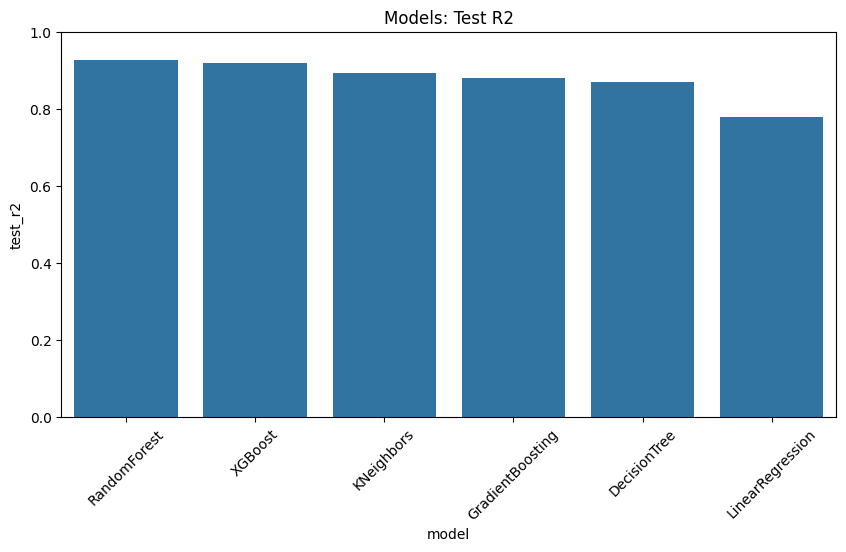

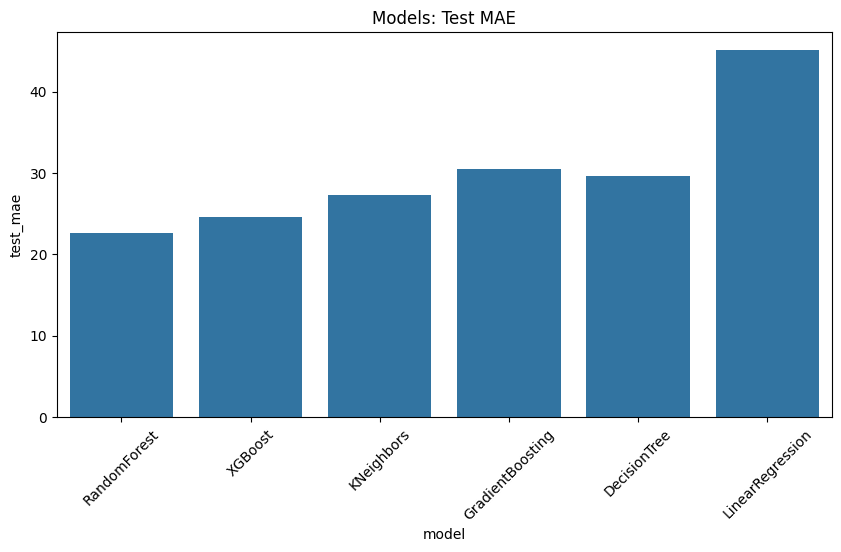

In [26]:
# %%
plt.figure(figsize=(10,5))
sns.barplot(data=results_df, x='model', y='test_r2')
plt.title("Models: Test R2")
plt.ylim(0,1)
plt.xticks(rotation=45)
plt.show()

plt.figure(figsize=(10,5))
sns.barplot(data=results_df, x='model', y='test_mae')
plt.title("Models: Test MAE")
plt.xticks(rotation=45)
plt.show()




In [28]:
# %%
best_row = results_df.loc[results_df['test_r2'].idxmax()]
best_name = best_row['model']
print("Best model:", best_name)
best_pipeline = models[best_name]
# Fit best pipeline on full training data (already fitted above) but we re-fit to be safe:
best_pipeline.fit(X_train, y_train)

# Save the pipeline and feature columns order (raw feature names before encoding)
joblib.dump(best_pipeline, 'aqi_pipeline.pkl')
# Save the final input feature list (columns of original X) so app can accept in same order
joblib.dump(list(X.columns), 'feature_columns.pkl')
print("Saved: aqi_pipeline.pkl and feature_columns.pkl")


Best model: RandomForest
Saved: aqi_pipeline.pkl and feature_columns.pkl


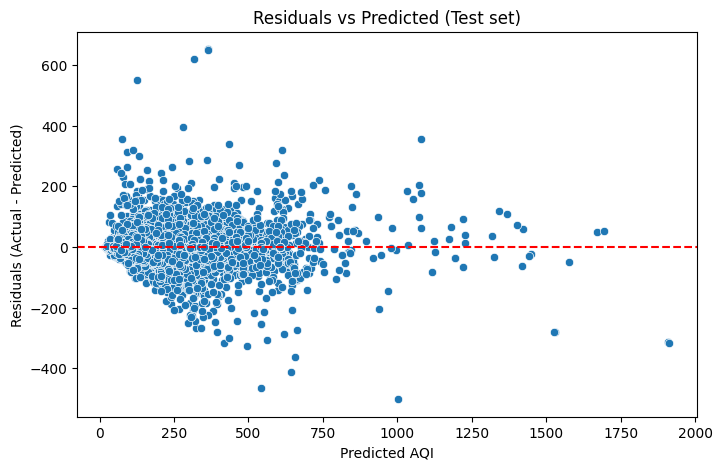

In [29]:
# %%
y_test_pred = best_pipeline.predict(X_test)
residuals = y_test - y_test_pred
plt.figure(figsize=(8,5))
sns.scatterplot(x=y_test_pred, y=residuals)
plt.axhline(0, color='red', linestyle='--')
plt.xlabel("Predicted AQI")
plt.ylabel("Residuals (Actual - Predicted)")
plt.title("Residuals vs Predicted (Test set)")
plt.show()


In [30]:
# %%
metrics_summary = {
    'best_model': best_name,
    'results_table': results_df.to_dict(orient='records')
}
import json
with open('metrics_summary.json', 'w') as f:
    json.dump(metrics_summary, f, indent=2)
print("Saved metrics_summary.json")


Saved metrics_summary.json
